In [1]:
import os
from glob import glob
import hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import ipynbname
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import re

# Constants
EXPERIMENT_NAME = "nursing_home"
DATA_PATH = f"..{os.sep}data{os.sep}"

In [2]:
current_time = datetime.now()
print("Current time is:",current_time)

nb_fname = ipynbname.name()
print("File:",nb_fname)

experiment_number = int(re.findall(r'\d+', nb_fname)[0])
print(f"Experiment Number: {experiment_number}")  # Output: 01

Current time is: 2024-12-05 21:52:27.765754
File: machine_learning_experiment10
Experiment Number: 10


In [3]:
# Function to generate a consistent hash number for a given file name
def generate_hash_number(file_name):
    """
    Generates a consistent hash number based on the file name.
    
    Args:
        file_name (str): The file name to hash.
    
    Returns:
        int: A 32-bit hash number.
    """
    # Create an MD5 hash object
    hash_obj = hashlib.md5()
    
    # Update the hash object with the file name, encoded to bytes
    hash_obj.update(file_name.encode())

    # Convert the hash to an integer and ensure the range fits 32-bit
    return int(hash_obj.hexdigest(), 16) % (2**32)

# Generate experiment seed from experiment name
initial_seed = generate_hash_number(EXPERIMENT_NAME)
print(f"Experiment Name: {EXPERIMENT_NAME}, Initial Seed: {initial_seed}")

Experiment Name: nursing_home, Initial Seed: 127573839


In [4]:
# Set the seed for reproducibility
np.random.seed(initial_seed)

# Generate a list of 5 random integers in the range of 32-bit integers
random_integers_list = np.random.randint(low=0, high=2**31 - 1, size=10).tolist()
print("Random Integers List:", random_integers_list)
seed = random_integers_list[experiment_number-1]
# Load clinical microbiome data
df_path = glob(f'{DATA_PATH}*clinical_microbiome_df*')[0]
print(f"Data File Path: {df_path}")

clinical_microbiome_df = pd.read_csv(df_path)
print("Clinical Microbiome Data Loaded.")

# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)

print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)
print(f"Seed in this experiment: {seed}")

Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Data File Path: ../data/clinical_microbiome_df.csv
Clinical Microbiome Data Loaded.
Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64
Seed in this experiment: 1770168448


In [5]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [6]:
clinical_microbiome_df = clinical_microbiome_df[clinical_microbiome_df["Dementia Other"] != 1]
# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)
print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)

Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64


In [7]:
clinical_summaries_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}clinical_summaries_df*")[0])
clinical_summaries_df

,Feature,Description,Group Characteristics,Summary
0,Sample ID,Unique identifier for biological or clinical s...,Study Identification,### Clinical Feature Summary\n\n#### Feature: ...
1,study_id,Identifier for the specific study or research ...,Study Identification,"### Clinical Feature Definitions, Scope, and R..."
2,day,Day of data collection or relevant event.,Temporal Information,### Clinical Feature Summary for Alzheimer's D...
3,Date Sample,Date when the sample was collected.,Temporal Information,### Clinical Feature Summary\n\n#### Feature: ...
4,age,Age of the participant.,Demographic Information,### Clinical Feature Summary: Age\n\n**Definit...
...,...,...,...,...
98,Severe Liver disease,Advanced liver disease diagnosis.,Hepatic Condition,### Clinical Feature: Severe Liver Disease\n\n...
99,ostomy,Presence of an ostomy.,Surgical History,### Clinical Feature: Ostomy\n\n**Definition:*...
100,Alzheimers,Diagnosis of Alzheimer’s disease.,Neurological Condition,### Clinical Feature Summary: Alzheimer's Dise...
101,Dementia Other,Other forms of dementia.,Neurological Condition,### Clinical Feature: Dementia Other\n\n**Defi...


In [8]:
clinical_summaries_df['Feature'].tolist()[:5]

['Sample ID', 'study_id', 'day', 'Date Sample', 'age']

In [9]:
clinical_summaries_df[['Feature']][clinical_summaries_df['Feature'].str.startswith(('c', 'C'))]

,Feature
10,clinical_frailty_scale
16,cholinesterase inhibitors
17,Calcium-channel blockers
58,Calcium Channel Modulators
59,Carbonic Anhydrase Inhibitor
60,Carboxamides
71,Chemotherapy Medication
81,COPD
86,Congestive heart failure
88,Cerebrovascular disease: CVA with mild or no r...


In [10]:
bacteria_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}bacteria_df*")[0])
bacteria_df.species_name.tolist()[:5]

['Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Eubacterium_siraeum',
 'Gemmiger_formicilis',
 'Eubacterium_rectale']

In [11]:
set(bacteria_df.species_name.tolist()[:5])

{'Eubacterium_rectale',
 'Eubacterium_siraeum',
 'Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Gemmiger_formicilis'}

In [12]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [13]:
import os
from math import ceil
from pynvml import nvmlInit, nvmlDeviceGetCount

# Function to get the number of GPUs available
def get_num_gpus():
    try:
        nvmlInit()
        return nvmlDeviceGetCount()
    except Exception as e:
        print(f"Error accessing NVML: {e}")
        return 0

# Function to list all .ipynb files in the current directory
def get_notebook_files():
    return [f for f in os.listdir('.') if f.endswith('.ipynb')]

# Function to evenly distribute files across GPUs
def distribute_files_evenly(files, num_gpus):
    """
    Distributes files evenly across all available GPUs.
    
    Args:
        files (list): List of file names to distribute.
        num_gpus (int): Number of GPUs available.
        
    Returns:
        dict: Distribution of files per GPU.
    """
    distribution = {f"cuda:{i}": [] for i in range(num_gpus)}
    for idx, file in enumerate(files):
        # Assign each file to a GPU in round-robin fashion
        gpu_id = idx % num_gpus
        distribution[f"cuda:{gpu_id}"].append(file)
    return distribution

# Function to get GPU ID for a specific notebook file
def get_gpu_for_file(nb_fname, file_distribution):
    """
    Finds the GPU ID for a given notebook file based on the distribution.
    
    Args:
        nb_fname (str): Notebook file name to find the GPU for.
        file_distribution (dict): Distribution of files per GPU.
    
    Returns:
        str: GPU ID (e.g., "cuda:0") or "Unassigned" if the file is not found.
    """
    for gpu, files in file_distribution.items():
        if nb_fname in files:
            return gpu
    return "cpu"

# Main logic for the notebook
def assign_notebooks_to_gpus():
    # Get the number of GPUs
    num_gpus = get_num_gpus()
    if num_gpus == 0:
        print("No GPUs available. Using CPU for all tasks.")
        return {"cpu": get_notebook_files()}
    
    # Get the list of .ipynb files
    notebook_files = get_notebook_files()
    if not notebook_files:
        print("No .ipynb files found in the current directory.")
        return {}
    
    # Evenly distribute files across GPUs
    file_distribution = distribute_files_evenly(notebook_files, num_gpus)
    
    # Display the distribution in the notebook
    for gpu, files in file_distribution.items():
        print(f"{gpu}: {files}")
    
    return file_distribution

# Run the assignment logic
file_distribution = assign_notebooks_to_gpus()

# Get the GPU ID for the specific notebook file
device = get_gpu_for_file(f"{nb_fname}.ipynb", file_distribution)

print(f"Initial seed: {initial_seed}")
print(f"Random Integers List: {random_integers_list}")
# Print the result
print(f"Notebook '{nb_fname}.ipynb' is assigned to device: {device} with seed {seed}.")

cuda:0: ['machine_learning_experiment03.ipynb', 'machine_learning_experiment06.ipynb', 'machine_learning_experiment08.ipynb']
cuda:1: ['machine_learning_experiment09.ipynb', 'machine_learning_experiment07.ipynb', 'machine_learning_experiment10.ipynb']
cuda:2: ['machine_learning_experiment02.ipynb', 'machine_learning_experiment04.ipynb']
cuda:3: ['machine_learning_experiment05.ipynb', 'machine_learning_experiment01.ipynb']
Initial seed: 127573839
Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Notebook 'machine_learning_experiment10.ipynb' is assigned to device: cuda:1 with seed 1770168448.


Experiment number: 10 | Seed number: 1770168448
No overlap Study ID found.
No overlap Sample ID found.


[I 2024-12-05 21:52:29,128] A new study created in memory with name: no-name-ae0594ac-5efd-41f6-8b72-4053813c6f25


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:52:34,139] Trial 0 finished with value: 0.7095719095719094 and parameters: {'threshold': 'median', 'max_features': 284, 'norm_order': 1, 'learning_rate': 0.20921534075866777, 'max_depth': 30, 'min_child_weight': 9, 'subsample': 0.9447292365458099, 'colsample_bytree': 0.8804710717955123, 'gamma': 3.377569153707082, 'reg_alpha': 4.081156715678501, 'reg_lambda': 8.28889796971952, 'n_estimators': 295}. Best is trial 0 with value: 0.7095719095719094.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:52:36,688] Trial 1 finished with value: 0.7658102927983036 and parameters: {'threshold': '1.5*mean', 'max_features': 598, 'norm_order': 2, 'learning_rate': 0.1923699384343232, 'max_depth': 13, 'min_child_weight': 8, 'subsample': 0.6669282138156258, 'colsample_bytree': 0.7729308362712278, 'gamma': 2.672885023636794, 'reg_alpha': 1.0390231300727004, 'reg_lambda': 6.9699817140303075, 'n_estimators': 59}. Best is trial 1 with value: 0.7658102927983036.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:52:40,429] Trial 2 finished with value: 0.6498316498316499 and parameters: {'threshold': '0.5*mean', 'max_features': 477, 'norm_order': 1, 'learning_rate': 0.31257550507827553, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6968165054544561, 'colsample_bytree': 0.7500923909297574, 'gamma': 6.916156298440583, 'reg_alpha': 8.734287553428516, 'reg_lambda': 4.78339948267668, 'n_estimators': 100}. Best is trial 1 with value: 0.7658102927983036.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:52:43,645] Trial 3 finished with value: 0.666750972007299 and parameters: {'threshold': '0.5*mean', 'max_features': 312, 'norm_order': 1, 'learning_rate': 0.06681604054972395, 'max_depth': 19, 'min_child_weight': 10, 'subsample': 0.7761995618580484, 'colsample_bytree': 0.6147598229526265, 'gamma': 6.33185203771074, 'reg_alpha': 7.1419495179871495, 'reg_lambda': 9.819189491623755, 'n_estimators': 145}. Best is trial 1 with value: 0.7658102927983036.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:52:47,564] Trial 4 finished with value: 0.7936938634507883 and parameters: {'threshold': 'very_low', 'max_features': 196, 'norm_order': 2, 'learning_rate': 0.17497875568871504, 'max_depth': 24, 'min_child_weight': 5, 'subsample': 0.7302484584193472, 'colsample_bytree': 0.9362143176769958, 'gamma': 0.9392820544281055, 'reg_alpha': 4.468473538915139, 'reg_lambda': 0.5518835996814053, 'n_estimators': 120}. Best is trial 4 with value: 0.7936938634507883.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:52:51,465] Trial 5 finished with value: 0.7291183353683354 and parameters: {'threshold': '0.5*mean', 'max_features': 450, 'norm_order': 2, 'learning_rate': 0.3670925243545049, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7665154279109541, 'colsample_bytree': 0.853372325114208, 'gamma': 4.716584301684167, 'reg_alpha': 2.6522469220037004, 'reg_lambda': 7.906254679731013, 'n_estimators': 244}. Best is trial 4 with value: 0.7936938634507883.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:52:55,543] Trial 6 finished with value: 0.697073820772899 and parameters: {'threshold': 'median', 'max_features': 397, 'norm_order': 1, 'learning_rate': 0.3653072411951212, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.6502275571179831, 'colsample_bytree': 0.667543627871855, 'gamma': 9.448911593877156, 'reg_alpha': 5.592107884378824, 'reg_lambda': 5.167365056128494, 'n_estimators': 160}. Best is trial 4 with value: 0.7936938634507883.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:52:58,920] Trial 7 finished with value: 0.647246525990736 and parameters: {'threshold': 'median', 'max_features': 242, 'norm_order': 2, 'learning_rate': 0.49835015401647953, 'max_depth': 12, 'min_child_weight': 5, 'subsample': 0.9725320121862651, 'colsample_bytree': 0.509881134954705, 'gamma': 9.335959111600651, 'reg_alpha': 7.254657945650267, 'reg_lambda': 5.5733090218323404, 'n_estimators': 280}. Best is trial 4 with value: 0.7936938634507883.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:03,400] Trial 8 finished with value: 0.6832504145936982 and parameters: {'threshold': 'median', 'max_features': 1043, 'norm_order': 1, 'learning_rate': 0.03576827617983786, 'max_depth': 18, 'min_child_weight': 7, 'subsample': 0.9596437515784384, 'colsample_bytree': 0.7455460571579973, 'gamma': 4.590460771744843, 'reg_alpha': 9.824780763598163, 'reg_lambda': 7.299716037277299, 'n_estimators': 236}. Best is trial 4 with value: 0.7936938634507883.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:06,704] Trial 9 finished with value: 0.7974747474747476 and parameters: {'threshold': '0.5*mean', 'max_features': 919, 'norm_order': 2, 'learning_rate': 0.1562025609086674, 'max_depth': 29, 'min_child_weight': 6, 'subsample': 0.7352802299163422, 'colsample_bytree': 0.5172716410365921, 'gamma': 1.6621454279774694, 'reg_alpha': 4.339132403695249, 'reg_lambda': 4.959097990530625, 'n_estimators': 100}. Best is trial 9 with value: 0.7974747474747476.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:11,104] Trial 10 finished with value: 0.8566701497735981 and parameters: {'threshold': 'mean', 'max_features': 972, 'norm_order': 2, 'learning_rate': 0.12678848741273063, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.5398993409312193, 'colsample_bytree': 0.5161762319386589, 'gamma': 0.07966373180739761, 'reg_alpha': 0.6485475861889896, 'reg_lambda': 2.3583171131105107, 'n_estimators': 62}. Best is trial 10 with value: 0.8566701497735981.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:14,523] Trial 11 finished with value: 0.8915731952832902 and parameters: {'threshold': 'mean', 'max_features': 1027, 'norm_order': 2, 'learning_rate': 0.11136165582041144, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.6006675616399766, 'colsample_bytree': 0.5138450850304972, 'gamma': 0.27153336733201705, 'reg_alpha': 0.07807936545480998, 'reg_lambda': 2.0947589723341, 'n_estimators': 51}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:17,769] Trial 12 finished with value: 0.8648632556662564 and parameters: {'threshold': 'mean', 'max_features': 753, 'norm_order': 2, 'learning_rate': 0.09540797877880319, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.5100018101583937, 'colsample_bytree': 0.5987780893248534, 'gamma': 0.08662189081755312, 'reg_alpha': 0.2227578563754012, 'reg_lambda': 1.6635990901269737, 'n_estimators': 53}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:21,344] Trial 13 finished with value: 0.8769020236028379 and parameters: {'threshold': 'mean', 'max_features': 799, 'norm_order': 2, 'learning_rate': 0.07108337378918252, 'max_depth': 24, 'min_child_weight': 1, 'subsample': 0.5008992990452037, 'colsample_bytree': 0.6035023938524354, 'gamma': 1.9406018810204828, 'reg_alpha': 0.17746631012875544, 'reg_lambda': 2.4628220004323795, 'n_estimators': 53}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:25,361] Trial 14 finished with value: 0.7313131313131315 and parameters: {'threshold': 'mean', 'max_features': 25, 'norm_order': 2, 'learning_rate': 0.023890175943006603, 'max_depth': 24, 'min_child_weight': 3, 'subsample': 0.5974813509831266, 'colsample_bytree': 0.597458180518407, 'gamma': 2.323119612254187, 'reg_alpha': 2.224697633015503, 'reg_lambda': 3.030506271008659, 'n_estimators': 199}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:29,250] Trial 15 finished with value: 0.822585978835979 and parameters: {'threshold': 'mean', 'max_features': 801, 'norm_order': 2, 'learning_rate': 0.2526519747179286, 'max_depth': 26, 'min_child_weight': 3, 'subsample': 0.579794587117499, 'colsample_bytree': 0.6488221320521376, 'gamma': 3.520463683777625, 'reg_alpha': 2.2465029942388592, 'reg_lambda': 0.41715971709426736, 'n_estimators': 92}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:33,191] Trial 16 finished with value: 0.8552895649084397 and parameters: {'threshold': 'mean', 'max_features': 655, 'norm_order': 2, 'learning_rate': 0.10304987046896177, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.5017001356836305, 'colsample_bytree': 0.5607400186975697, 'gamma': 1.0317277860017984, 'reg_alpha': 1.502533686859263, 'reg_lambda': 3.2103952435065777, 'n_estimators': 193}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:36,635] Trial 17 finished with value: 0.8259314456035768 and parameters: {'threshold': '1.5*mean', 'max_features': 845, 'norm_order': 2, 'learning_rate': 0.25049400579354214, 'max_depth': 14, 'min_child_weight': 4, 'subsample': 0.8691778523690684, 'colsample_bytree': 0.6954623093524372, 'gamma': 1.5413589435301756, 'reg_alpha': 3.459505678986811, 'reg_lambda': 3.737160995528426, 'n_estimators': 81}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:40,728] Trial 18 finished with value: 0.7111742424242425 and parameters: {'threshold': 'mean', 'max_features': 689, 'norm_order': 2, 'learning_rate': 0.012933940261454752, 'max_depth': 27, 'min_child_weight': 1, 'subsample': 0.5956035869858146, 'colsample_bytree': 0.563871245831253, 'gamma': 6.620636152009979, 'reg_alpha': 5.622816290684286, 'reg_lambda': 0.898935132483559, 'n_estimators': 128}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:44,660] Trial 19 finished with value: 0.7843836013327539 and parameters: {'threshold': 'very_low', 'max_features': 903, 'norm_order': 2, 'learning_rate': 0.1327471590952613, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.5593903462814009, 'colsample_bytree': 0.7043503843821303, 'gamma': 3.6569661709805996, 'reg_alpha': 0.30760762940003517, 'reg_lambda': 1.6805737063574107, 'n_estimators': 78}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:48,569] Trial 20 finished with value: 0.8211238478710436 and parameters: {'threshold': 'mean', 'max_features': 1035, 'norm_order': 1, 'learning_rate': 0.062463124515424136, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6304910863337687, 'colsample_bytree': 0.8161792083641587, 'gamma': 2.6674513819725134, 'reg_alpha': 1.5792157503037494, 'reg_lambda': 4.167026232142965, 'n_estimators': 122}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:52,429] Trial 21 finished with value: 0.8627565982404691 and parameters: {'threshold': 'mean', 'max_features': 756, 'norm_order': 2, 'learning_rate': 0.08572149276418328, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.54399081021524, 'colsample_bytree': 0.5822856769771563, 'gamma': 0.06040958003018714, 'reg_alpha': 0.009021280546512966, 'reg_lambda': 1.7829146073151065, 'n_estimators': 54}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:55,997] Trial 22 finished with value: 0.8585858585858587 and parameters: {'threshold': 'mean', 'max_features': 728, 'norm_order': 2, 'learning_rate': 0.10977470123270532, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.5010943352690289, 'colsample_bytree': 0.6132279163038383, 'gamma': 0.5758593628796893, 'reg_alpha': 0.7646229862136169, 'reg_lambda': 1.8208772736083387, 'n_estimators': 52}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:53:59,407] Trial 23 finished with value: 0.8886503599618353 and parameters: {'threshold': 'mean', 'max_features': 574, 'norm_order': 2, 'learning_rate': 0.1498791112207595, 'max_depth': 27, 'min_child_weight': 2, 'subsample': 0.5055893782973209, 'colsample_bytree': 0.5499751907387181, 'gamma': 1.4026995446610733, 'reg_alpha': 0.01838252628027634, 'reg_lambda': 2.455288873691316, 'n_estimators': 76}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:03,187] Trial 24 finished with value: 0.7832167832167832 and parameters: {'threshold': 'mean', 'max_features': 558, 'norm_order': 2, 'learning_rate': 0.22168340527737385, 'max_depth': 28, 'min_child_weight': 4, 'subsample': 0.621703477560434, 'colsample_bytree': 0.539513820445642, 'gamma': 2.009784461641622, 'reg_alpha': 2.8731719625353813, 'reg_lambda': 2.8180494960611413, 'n_estimators': 78}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:07,011] Trial 25 finished with value: 0.840372302883646 and parameters: {'threshold': '1.5*mean', 'max_features': 869, 'norm_order': 2, 'learning_rate': 0.15050882983695202, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.543705703119237, 'colsample_bytree': 0.64570619493329, 'gamma': 1.0744078443366947, 'reg_alpha': 1.5650822361118288, 'reg_lambda': 3.875584157462473, 'n_estimators': 107}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:10,356] Trial 26 finished with value: 0.7582671957671958 and parameters: {'threshold': 'mean', 'max_features': 623, 'norm_order': 2, 'learning_rate': 0.054116761569694444, 'max_depth': 28, 'min_child_weight': 4, 'subsample': 0.576599934023923, 'colsample_bytree': 0.5032742121406161, 'gamma': 5.4609913342170024, 'reg_alpha': 1.3334161737866632, 'reg_lambda': 6.1631522635722895, 'n_estimators': 143}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:14,620] Trial 27 finished with value: 0.7931556948798328 and parameters: {'threshold': 'very_low', 'max_features': 949, 'norm_order': 2, 'learning_rate': 0.17782809054203924, 'max_depth': 30, 'min_child_weight': 3, 'subsample': 0.8216382927271688, 'colsample_bytree': 0.5552475064162825, 'gamma': 7.896053973510334, 'reg_alpha': 0.023204007921014652, 'reg_lambda': 1.0501347234810234, 'n_estimators': 78}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:17,617] Trial 28 finished with value: 0.7959108003601886 and parameters: {'threshold': 'mean', 'max_features': 796, 'norm_order': 2, 'learning_rate': 0.30214230690417654, 'max_depth': 27, 'min_child_weight': 2, 'subsample': 0.6853893103740285, 'colsample_bytree': 0.6355431273745187, 'gamma': 4.134834188377773, 'reg_alpha': 1.9405271501400663, 'reg_lambda': 2.539806751876506, 'n_estimators': 72}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:21,289] Trial 29 finished with value: 0.8278815317864554 and parameters: {'threshold': 'mean', 'max_features': 962, 'norm_order': 1, 'learning_rate': 0.20511458990826922, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.8956102615897656, 'colsample_bytree': 0.6898958423673984, 'gamma': 3.2097047351746255, 'reg_alpha': 3.4909476425979786, 'reg_lambda': 3.517828473685448, 'n_estimators': 183}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:26,005] Trial 30 finished with value: 0.8118348233290762 and parameters: {'threshold': 'mean', 'max_features': 531, 'norm_order': 2, 'learning_rate': 0.4720925701899743, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.5295903514357507, 'colsample_bytree': 0.5395790679034802, 'gamma': 1.6043524617465637, 'reg_alpha': 0.9184612121460931, 'reg_lambda': 0.20673410805320191, 'n_estimators': 92}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:30,156] Trial 31 finished with value: 0.8745725506336712 and parameters: {'threshold': 'mean', 'max_features': 680, 'norm_order': 2, 'learning_rate': 0.08447277716635944, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.5088755181102441, 'colsample_bytree': 0.5823716489227594, 'gamma': 0.4483803863569018, 'reg_alpha': 0.015430784072127779, 'reg_lambda': 1.5938474283790862, 'n_estimators': 66}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:33,934] Trial 32 finished with value: 0.8449874686716793 and parameters: {'threshold': 'mean', 'max_features': 582, 'norm_order': 2, 'learning_rate': 0.07819071064297198, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.527209517829755, 'colsample_bytree': 0.9903463371327008, 'gamma': 0.717421754521418, 'reg_alpha': 0.9890460173816487, 'reg_lambda': 1.1873155680345169, 'n_estimators': 68}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:38,071] Trial 33 finished with value: 0.8457285652200907 and parameters: {'threshold': '1.5*mean', 'max_features': 681, 'norm_order': 2, 'learning_rate': 0.11770303468740416, 'max_depth': 28, 'min_child_weight': 2, 'subsample': 0.6120997609463049, 'colsample_bytree': 0.5777074863224153, 'gamma': 2.811161051574363, 'reg_alpha': 0.6310732614896224, 'reg_lambda': 2.3111151142426483, 'n_estimators': 52}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:42,103] Trial 34 finished with value: 0.8233790691417809 and parameters: {'threshold': 'mean', 'max_features': 464, 'norm_order': 2, 'learning_rate': 0.0412186202670605, 'max_depth': 20, 'min_child_weight': 3, 'subsample': 0.5808127619513985, 'colsample_bytree': 0.5413487734501256, 'gamma': 2.109232395294607, 'reg_alpha': 0.06186937957857098, 'reg_lambda': 2.112044848030998, 'n_estimators': 89}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:46,115] Trial 35 finished with value: 0.8338698554946363 and parameters: {'threshold': 'very_low', 'max_features': 348, 'norm_order': 2, 'learning_rate': 0.141648088436955, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.6557921783439609, 'colsample_bytree': 0.7317255853053496, 'gamma': 1.263049293030059, 'reg_alpha': 1.1848850150180181, 'reg_lambda': 4.286395856781019, 'n_estimators': 113}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:49,982] Trial 36 finished with value: 0.8401477832512315 and parameters: {'threshold': '0.5*mean', 'max_features': 604, 'norm_order': 2, 'learning_rate': 0.17663749178685434, 'max_depth': 26, 'min_child_weight': 2, 'subsample': 0.5548336376789844, 'colsample_bytree': 0.6178357543505508, 'gamma': 0.5478842913650814, 'reg_alpha': 2.718943614120339, 'reg_lambda': 9.606634017183119, 'n_estimators': 67}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:54,106] Trial 37 finished with value: 0.6888074888074889 and parameters: {'threshold': 'mean', 'max_features': 831, 'norm_order': 1, 'learning_rate': 0.07303036228882975, 'max_depth': 24, 'min_child_weight': 8, 'subsample': 0.5005984359834804, 'colsample_bytree': 0.8098992991980374, 'gamma': 5.446694658908419, 'reg_alpha': 6.985163960787254, 'reg_lambda': 0.039004851990577016, 'n_estimators': 142}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:54:57,560] Trial 38 finished with value: 0.8349691349664262 and parameters: {'threshold': 'median', 'max_features': 526, 'norm_order': 2, 'learning_rate': 0.22743792858866768, 'max_depth': 28, 'min_child_weight': 4, 'subsample': 0.6940462976266787, 'colsample_bytree': 0.5840930298921579, 'gamma': 0.5573091390533385, 'reg_alpha': 0.6733218311725204, 'reg_lambda': 3.1683930289705544, 'n_estimators': 102}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:01,974] Trial 39 finished with value: 0.7487670224512329 and parameters: {'threshold': 'mean', 'max_features': 721, 'norm_order': 2, 'learning_rate': 0.29523532789348933, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.563050152975943, 'colsample_bytree': 0.6660372700427412, 'gamma': 2.5471891324036813, 'reg_alpha': 6.226173994514401, 'reg_lambda': 0.9801480458322829, 'n_estimators': 299}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:06,682] Trial 40 finished with value: 0.7817617342772798 and parameters: {'threshold': '0.5*mean', 'max_features': 1011, 'norm_order': 1, 'learning_rate': 0.15390156621775922, 'max_depth': 16, 'min_child_weight': 9, 'subsample': 0.642177858930727, 'colsample_bytree': 0.8927460140693891, 'gamma': 1.8555144412171947, 'reg_alpha': 1.931872350661899, 'reg_lambda': 4.4527106782817585, 'n_estimators': 227}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:10,341] Trial 41 finished with value: 0.863222510608495 and parameters: {'threshold': 'mean', 'max_features': 766, 'norm_order': 2, 'learning_rate': 0.09441489048566615, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.5267169537771134, 'colsample_bytree': 0.6025303919467828, 'gamma': 0.23471966022194557, 'reg_alpha': 0.4233458254248652, 'reg_lambda': 1.3664352748027295, 'n_estimators': 51}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:14,118] Trial 42 finished with value: 0.8593090460419508 and parameters: {'threshold': 'mean', 'max_features': 399, 'norm_order': 2, 'learning_rate': 0.05419579567687198, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.5116044532282746, 'colsample_bytree': 0.5438608220836638, 'gamma': 1.229166245643436, 'reg_alpha': 0.015919910458570025, 'reg_lambda': 2.6068625192585673, 'n_estimators': 64}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:17,809] Trial 43 finished with value: 0.8273176109673089 and parameters: {'threshold': 'mean', 'max_features': 628, 'norm_order': 2, 'learning_rate': 0.09889697019951026, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.5246402196260973, 'colsample_bytree': 0.5217985224633297, 'gamma': 0.25759603985668833, 'reg_alpha': 8.87759334574006, 'reg_lambda': 1.5029852163437312, 'n_estimators': 62}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:21,605] Trial 44 finished with value: 0.8114743072370191 and parameters: {'threshold': 'median', 'max_features': 877, 'norm_order': 2, 'learning_rate': 0.034360986936425454, 'max_depth': 29, 'min_child_weight': 2, 'subsample': 0.5973409939071261, 'colsample_bytree': 0.6149285563201078, 'gamma': 0.8943229169060969, 'reg_alpha': 1.0213446187629212, 'reg_lambda': 2.0040046345690192, 'n_estimators': 87}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:25,373] Trial 45 finished with value: 0.8214509909425164 and parameters: {'threshold': 'mean', 'max_features': 489, 'norm_order': 2, 'learning_rate': 0.12616119497487033, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.5607336997645933, 'colsample_bytree': 0.5762177676718601, 'gamma': 1.42060693525221, 'reg_alpha': 0.47007990686432005, 'reg_lambda': 3.375442719566572, 'n_estimators': 68}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:29,968] Trial 46 finished with value: 0.8652844231791601 and parameters: {'threshold': '1.5*mean', 'max_features': 802, 'norm_order': 2, 'learning_rate': 0.07990238051140637, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5199679685595868, 'colsample_bytree': 0.5025760942152236, 'gamma': 0.0846823063072284, 'reg_alpha': 1.8775809002685302, 'reg_lambda': 0.6915957334574192, 'n_estimators': 164}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:35,708] Trial 47 finished with value: 0.7717081963066027 and parameters: {'threshold': '1.5*mean', 'max_features': 807, 'norm_order': 2, 'learning_rate': 0.012935687440028668, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7142758348760728, 'colsample_bytree': 0.5007265477187477, 'gamma': 8.714056526896536, 'reg_alpha': 1.9107744899785093, 'reg_lambda': 0.8684332991354291, 'n_estimators': 267}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:39,060] Trial 48 finished with value: 0.7885710622886721 and parameters: {'threshold': '1.5*mean', 'max_features': 151, 'norm_order': 2, 'learning_rate': 0.19202021724530677, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9981662312062739, 'colsample_bytree': 0.5272203970733222, 'gamma': 3.1428108404618804, 'reg_alpha': 3.4307268668749513, 'reg_lambda': 0.463478070938208, 'n_estimators': 172}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:42,613] Trial 49 finished with value: 0.8397280233122876 and parameters: {'threshold': '1.5*mean', 'max_features': 676, 'norm_order': 2, 'learning_rate': 0.3902548746198078, 'max_depth': 14, 'min_child_weight': 3, 'subsample': 0.7609869088793827, 'colsample_bytree': 0.5281242535806163, 'gamma': 0.5217866303632034, 'reg_alpha': 4.925563096229365, 'reg_lambda': 0.6485338657842377, 'n_estimators': 158}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:47,685] Trial 50 finished with value: 0.8593067156849493 and parameters: {'threshold': '1.5*mean', 'max_features': 918, 'norm_order': 2, 'learning_rate': 0.06674852772955402, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.7968423874613277, 'colsample_bytree': 0.5615611536944586, 'gamma': 2.220979322002873, 'reg_alpha': 1.1944317710593046, 'reg_lambda': 2.229717142172861, 'n_estimators': 207}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:51,244] Trial 51 finished with value: 0.8615098351940458 and parameters: {'threshold': 'mean', 'max_features': 743, 'norm_order': 2, 'learning_rate': 0.09217950696648847, 'max_depth': 27, 'min_child_weight': 1, 'subsample': 0.5221690640736716, 'colsample_bytree': 0.5966864928961629, 'gamma': 0.06943062162160903, 'reg_alpha': 0.31656383535218485, 'reg_lambda': 1.405885851240815, 'n_estimators': 50}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:55,252] Trial 52 finished with value: 0.7849766113844846 and parameters: {'threshold': '0.5*mean', 'max_features': 783, 'norm_order': 2, 'learning_rate': 0.1105329306326174, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.5433158345140653, 'colsample_bytree': 0.6278557607346762, 'gamma': 0.8644805199391785, 'reg_alpha': 0.51445100691957, 'reg_lambda': 2.5905837394404507, 'n_estimators': 131}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:55:58,685] Trial 53 finished with value: 0.7862733034308471 and parameters: {'threshold': 'very_low', 'max_features': 702, 'norm_order': 2, 'learning_rate': 0.043409931169812725, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.5130911074988634, 'colsample_bytree': 0.5587525861485115, 'gamma': 0.03005192339268377, 'reg_alpha': 2.2474355464494886, 'reg_lambda': 2.8847734807734233, 'n_estimators': 95}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:02,873] Trial 54 finished with value: 0.8490461418573633 and parameters: {'threshold': 'mean', 'max_features': 647, 'norm_order': 2, 'learning_rate': 0.1321806613842156, 'max_depth': 29, 'min_child_weight': 1, 'subsample': 0.5741107854471553, 'colsample_bytree': 0.6578850101480032, 'gamma': 1.5713320469594751, 'reg_alpha': 1.4873939571017818, 'reg_lambda': 1.7700203102931544, 'n_estimators': 80}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:06,972] Trial 55 finished with value: 0.8025249670246843 and parameters: {'threshold': 'median', 'max_features': 840, 'norm_order': 2, 'learning_rate': 0.16096571384613984, 'max_depth': 26, 'min_child_weight': 2, 'subsample': 0.501872534173241, 'colsample_bytree': 0.5153953624125247, 'gamma': 1.1283955825961693, 'reg_alpha': 0.9336023042686568, 'reg_lambda': 5.381813077234351, 'n_estimators': 111}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:10,732] Trial 56 finished with value: 0.8481678798404985 and parameters: {'threshold': 'mean', 'max_features': 1001, 'norm_order': 2, 'learning_rate': 0.07585668420842794, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.5434828522428449, 'colsample_bytree': 0.5815200320884185, 'gamma': 0.5085518167242681, 'reg_alpha': 0.30703463816758475, 'reg_lambda': 6.432818298725127, 'n_estimators': 61}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:14,450] Trial 57 finished with value: 0.8607313738892687 and parameters: {'threshold': '1.5*mean', 'max_features': 580, 'norm_order': 2, 'learning_rate': 0.1171303684176215, 'max_depth': 24, 'min_child_weight': 1, 'subsample': 0.5909270502373682, 'colsample_bytree': 0.5009190888839739, 'gamma': 1.867290697916629, 'reg_alpha': 1.6570538057191375, 'reg_lambda': 0.8014648399448618, 'n_estimators': 59}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:18,857] Trial 58 finished with value: 0.7984737484737484 and parameters: {'threshold': 'mean', 'max_features': 878, 'norm_order': 2, 'learning_rate': 0.027990153707326715, 'max_depth': 30, 'min_child_weight': 3, 'subsample': 0.558844528700041, 'colsample_bytree': 0.6811829169239811, 'gamma': 0.9736589884130571, 'reg_alpha': 2.334218521254786, 'reg_lambda': 1.567616072563762, 'n_estimators': 74}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:22,311] Trial 59 finished with value: 0.8650860712096361 and parameters: {'threshold': 'mean', 'max_features': 427, 'norm_order': 2, 'learning_rate': 0.08284447236838521, 'max_depth': 27, 'min_child_weight': 2, 'subsample': 0.6147892782225586, 'colsample_bytree': 0.7255334443128751, 'gamma': 0.42882626660759726, 'reg_alpha': 0.75055761285532, 'reg_lambda': 1.9518532620841755, 'n_estimators': 85}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:26,392] Trial 60 finished with value: 0.7521586362074508 and parameters: {'threshold': 'mean', 'max_features': 385, 'norm_order': 2, 'learning_rate': 0.056537721227215766, 'max_depth': 27, 'min_child_weight': 10, 'subsample': 0.6236462824687626, 'colsample_bytree': 0.7874701328841166, 'gamma': 3.9561382819469384, 'reg_alpha': 0.6182963550556604, 'reg_lambda': 2.1281413929749737, 'n_estimators': 86}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:30,770] Trial 61 finished with value: 0.8554667437082691 and parameters: {'threshold': 'mean', 'max_features': 419, 'norm_order': 2, 'learning_rate': 0.08811366284603706, 'max_depth': 29, 'min_child_weight': 2, 'subsample': 0.5358343212882926, 'colsample_bytree': 0.7347359668837562, 'gamma': 0.35109247725097426, 'reg_alpha': 0.002847008041333171, 'reg_lambda': 2.8160532609871582, 'n_estimators': 71}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:34,246] Trial 62 finished with value: 0.8726998890905424 and parameters: {'threshold': 'mean', 'max_features': 282, 'norm_order': 2, 'learning_rate': 0.10163791404540855, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.610448981619488, 'colsample_bytree': 0.5940623243967538, 'gamma': 0.808481635320011, 'reg_alpha': 0.8488087402000621, 'reg_lambda': 1.1338400094024603, 'n_estimators': 58}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:38,245] Trial 63 finished with value: 0.8318154219793564 and parameters: {'threshold': 'mean', 'max_features': 256, 'norm_order': 2, 'learning_rate': 0.13678308518734922, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.6122255474783204, 'colsample_bytree': 0.7140058973761808, 'gamma': 1.360810255504257, 'reg_alpha': 1.1966331106825638, 'reg_lambda': 1.2042370407488068, 'n_estimators': 97}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:41,162] Trial 64 finished with value: 0.8817733990147784 and parameters: {'threshold': 'mean', 'max_features': 496, 'norm_order': 2, 'learning_rate': 0.10596260577166997, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.6703002996319152, 'colsample_bytree': 0.8680114526451862, 'gamma': 0.8076998651721792, 'reg_alpha': 0.3873584143518476, 'reg_lambda': 0.32473083966193644, 'n_estimators': 59}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:44,038] Trial 65 finished with value: 0.8764619883040936 and parameters: {'threshold': 'mean', 'max_features': 184, 'norm_order': 2, 'learning_rate': 0.10455774688658823, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.6591679832220552, 'colsample_bytree': 0.851167479263328, 'gamma': 0.81870239517018, 'reg_alpha': 0.8486416404385633, 'reg_lambda': 0.12447222196520968, 'n_estimators': 58}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:47,396] Trial 66 finished with value: 0.8749520369414784 and parameters: {'threshold': 'mean', 'max_features': 159, 'norm_order': 2, 'learning_rate': 0.10591994325011612, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.682349908335277, 'colsample_bytree': 0.8769902166301721, 'gamma': 1.756353453812787, 'reg_alpha': 0.3383328318801645, 'reg_lambda': 0.27344241128326996, 'n_estimators': 57}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:50,949] Trial 67 finished with value: 0.8419166195057537 and parameters: {'threshold': 'mean', 'max_features': 176, 'norm_order': 2, 'learning_rate': 0.16513490392114918, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.67679334262163, 'colsample_bytree': 0.876710053296871, 'gamma': 2.3100035298611137, 'reg_alpha': 0.3152117055879925, 'reg_lambda': 0.3058106204333919, 'n_estimators': 74}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:54,310] Trial 68 finished with value: 0.8697338268993478 and parameters: {'threshold': 'mean', 'max_features': 44, 'norm_order': 1, 'learning_rate': 0.12227626054385644, 'max_depth': 28, 'min_child_weight': 2, 'subsample': 0.6674580300152554, 'colsample_bytree': 0.8597836140547602, 'gamma': 1.830583166680623, 'reg_alpha': 1.3363539764136738, 'reg_lambda': 0.23188812824278582, 'n_estimators': 60}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:56:57,576] Trial 69 finished with value: 0.8341625207296849 and parameters: {'threshold': 'mean', 'max_features': 133, 'norm_order': 2, 'learning_rate': 0.14042394165667038, 'max_depth': 24, 'min_child_weight': 5, 'subsample': 0.7147432639570825, 'colsample_bytree': 0.9522700324662615, 'gamma': 2.658601631754248, 'reg_alpha': 0.49247000244893946, 'reg_lambda': 0.04249639529000686, 'n_estimators': 68}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:00,341] Trial 70 finished with value: 0.7973684210526315 and parameters: {'threshold': 'very_low', 'max_features': 320, 'norm_order': 2, 'learning_rate': 0.19699600957168362, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.7364140140623007, 'colsample_bytree': 0.9255183823986157, 'gamma': 3.0219759869514746, 'reg_alpha': 0.24414665943617342, 'reg_lambda': 0.5720229543710045, 'n_estimators': 57}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:03,867] Trial 71 finished with value: 0.8571120689655173 and parameters: {'threshold': 'mean', 'max_features': 211, 'norm_order': 2, 'learning_rate': 0.10666913026488874, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.6422509049340244, 'colsample_bytree': 0.8505850085695762, 'gamma': 0.8148373781959315, 'reg_alpha': 0.7889015822586383, 'reg_lambda': 1.0593666651275575, 'n_estimators': 57}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:07,013] Trial 72 finished with value: 0.8571985193843755 and parameters: {'threshold': 'mean', 'max_features': 94, 'norm_order': 2, 'learning_rate': 0.10786186443025805, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.6598804207526385, 'colsample_bytree': 0.9042500784044836, 'gamma': 1.5805932691387055, 'reg_alpha': 0.9157410495406251, 'reg_lambda': 0.4429652947393359, 'n_estimators': 79}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:10,237] Trial 73 finished with value: 0.8346560846560847 and parameters: {'threshold': 'mean', 'max_features': 279, 'norm_order': 2, 'learning_rate': 0.059706204758956605, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.698225883023142, 'colsample_bytree': 0.8558357683127669, 'gamma': 1.0873165911904135, 'reg_alpha': 0.023555114842012198, 'reg_lambda': 1.1924663164824811, 'n_estimators': 50}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:13,700] Trial 74 finished with value: 0.8531942633637549 and parameters: {'threshold': 'mean', 'max_features': 220, 'norm_order': 2, 'learning_rate': 0.14567762687344038, 'max_depth': 29, 'min_child_weight': 1, 'subsample': 0.6344451726205202, 'colsample_bytree': 0.8140722392351121, 'gamma': 0.718802672887959, 'reg_alpha': 0.6549799520181712, 'reg_lambda': 7.974359051605613, 'n_estimators': 65}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:17,522] Trial 75 finished with value: 0.854775828460039 and parameters: {'threshold': 'mean', 'max_features': 109, 'norm_order': 2, 'learning_rate': 0.1007510236046681, 'max_depth': 27, 'min_child_weight': 2, 'subsample': 0.6729402988746338, 'colsample_bytree': 0.8283570059104779, 'gamma': 1.3276346143055155, 'reg_alpha': 1.128877819219439, 'reg_lambda': 3.8042573572682055, 'n_estimators': 75}. Best is trial 11 with value: 0.8915731952832902.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:21,010] Trial 76 finished with value: 0.9047609754828302 and parameters: {'threshold': 'mean', 'max_features': 53, 'norm_order': 2, 'learning_rate': 0.16941421939564302, 'max_depth': 28, 'min_child_weight': 1, 'subsample': 0.6483902862553054, 'colsample_bytree': 0.770267300923401, 'gamma': 1.8378517101830592, 'reg_alpha': 0.2886511977182928, 'reg_lambda': 0.014373260341841526, 'n_estimators': 60}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:25,664] Trial 77 finished with value: 0.8048812764670297 and parameters: {'threshold': '0.5*mean', 'max_features': 80, 'norm_order': 2, 'learning_rate': 0.17553560699163337, 'max_depth': 30, 'min_child_weight': 2, 'subsample': 0.6511074872543625, 'colsample_bytree': 0.7893936749687859, 'gamma': 7.344644963462539, 'reg_alpha': 0.236057404831442, 'reg_lambda': 0.1902354206960822, 'n_estimators': 105}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:28,774] Trial 78 finished with value: 0.7013830532212886 and parameters: {'threshold': 'mean', 'max_features': 11, 'norm_order': 2, 'learning_rate': 0.22210243373665647, 'max_depth': 28, 'min_child_weight': 1, 'subsample': 0.7098154629675261, 'colsample_bytree': 0.8316126977397131, 'gamma': 2.424230438506198, 'reg_alpha': 7.757821215494642, 'reg_lambda': 0.5927492429629709, 'n_estimators': 85}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:31,211] Trial 79 finished with value: 0.8584039548022598 and parameters: {'threshold': 'mean', 'max_features': 55, 'norm_order': 2, 'learning_rate': 0.12161396865502903, 'max_depth': 27, 'min_child_weight': 1, 'subsample': 0.7438838692729837, 'colsample_bytree': 0.769344478524096, 'gamma': 2.109036582870928, 'reg_alpha': 1.6912816741512706, 'reg_lambda': 0.8336197580525376, 'n_estimators': 65}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:34,099] Trial 80 finished with value: 0.7630700778642936 and parameters: {'threshold': 'median', 'max_features': 492, 'norm_order': 2, 'learning_rate': 0.2796947471832263, 'max_depth': 29, 'min_child_weight': 6, 'subsample': 0.6865536788597322, 'colsample_bytree': 0.8763893450853094, 'gamma': 1.7170006386095706, 'reg_alpha': 0.36013640195882063, 'reg_lambda': 2.3995363642698933, 'n_estimators': 70}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:36,674] Trial 81 finished with value: 0.840530303030303 and parameters: {'threshold': 'mean', 'max_features': 135, 'norm_order': 2, 'learning_rate': 0.045598134910953325, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.6009188243513288, 'colsample_bytree': 0.8960297793078231, 'gamma': 0.8178246886090408, 'reg_alpha': 0.8493295508302059, 'reg_lambda': 1.551958749228991, 'n_estimators': 56}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:39,433] Trial 82 finished with value: 0.8482316903369534 and parameters: {'threshold': 'mean', 'max_features': 237, 'norm_order': 2, 'learning_rate': 0.15508323421847386, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.6320114365529483, 'colsample_bytree': 0.9141490869563542, 'gamma': 1.1679878153084369, 'reg_alpha': 1.3237270810074429, 'reg_lambda': 0.1264967922887143, 'n_estimators': 56}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:42,337] Trial 83 finished with value: 0.8411700109813317 and parameters: {'threshold': 'mean', 'max_features': 171, 'norm_order': 2, 'learning_rate': 0.09576934826530321, 'max_depth': 28, 'min_child_weight': 2, 'subsample': 0.6617876608921631, 'colsample_bytree': 0.5501633993976998, 'gamma': 1.4117031028332219, 'reg_alpha': 0.5592563128928145, 'reg_lambda': 0.02689698971141824, 'n_estimators': 50}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:45,288] Trial 84 finished with value: 0.8872988009877719 and parameters: {'threshold': 'mean', 'max_features': 346, 'norm_order': 2, 'learning_rate': 0.07311082780907491, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.6464918169361134, 'colsample_bytree': 0.5707028226973323, 'gamma': 0.6413888310112452, 'reg_alpha': 0.18526014958032538, 'reg_lambda': 1.2448520400965424, 'n_estimators': 63}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:48,092] Trial 85 finished with value: 0.7681825552809616 and parameters: {'threshold': 'mean', 'max_features': 573, 'norm_order': 2, 'learning_rate': 0.06700769795502336, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.6407733882496585, 'colsample_bytree': 0.7635042325373766, 'gamma': 6.011145591883702, 'reg_alpha': 0.006984029152860172, 'reg_lambda': 9.060322674136554, 'n_estimators': 82}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:51,437] Trial 86 finished with value: 0.8662612971823499 and parameters: {'threshold': 'mean', 'max_features': 540, 'norm_order': 2, 'learning_rate': 0.1885456717332852, 'max_depth': 24, 'min_child_weight': 2, 'subsample': 0.721829460577545, 'colsample_bytree': 0.8445641727921409, 'gamma': 0.28265246916748016, 'reg_alpha': 0.4967742790569448, 'reg_lambda': 1.3617716855429038, 'n_estimators': 64}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:54,993] Trial 87 finished with value: 0.881091617933723 and parameters: {'threshold': 'mean', 'max_features': 352, 'norm_order': 2, 'learning_rate': 0.08349669283329805, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.6976232462803653, 'colsample_bytree': 0.9568413839892271, 'gamma': 0.6046046894869054, 'reg_alpha': 0.22450398664444499, 'reg_lambda': 1.8440964900729064, 'n_estimators': 91}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:57:58,831] Trial 88 finished with value: 0.8450962739638074 and parameters: {'threshold': 'mean', 'max_features': 322, 'norm_order': 2, 'learning_rate': 0.12868350045647084, 'max_depth': 26, 'min_child_weight': 2, 'subsample': 0.694102131131826, 'colsample_bytree': 0.95434362316781, 'gamma': 1.9688020937651047, 'reg_alpha': 1.017542070563366, 'reg_lambda': 0.41185476086779915, 'n_estimators': 91}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:58:02,224] Trial 89 finished with value: 0.8375750898966411 and parameters: {'threshold': 'very_low', 'max_features': 355, 'norm_order': 2, 'learning_rate': 0.07256184594973421, 'max_depth': 28, 'min_child_weight': 1, 'subsample': 0.6869513122350255, 'colsample_bytree': 0.9932692560488146, 'gamma': 2.8224386551790035, 'reg_alpha': 0.3178367758865829, 'reg_lambda': 1.8258982888234234, 'n_estimators': 75}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:58:05,045] Trial 90 finished with value: 0.7787959578838333 and parameters: {'threshold': 'mean', 'max_features': 450, 'norm_order': 2, 'learning_rate': 0.1646284842702349, 'max_depth': 24, 'min_child_weight': 1, 'subsample': 0.6765428806404441, 'colsample_bytree': 0.9778697703153346, 'gamma': 4.68650001003035, 'reg_alpha': 3.8004252308954225, 'reg_lambda': 0.7359723295739165, 'n_estimators': 70}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:58:07,810] Trial 91 finished with value: 0.879455287019247 and parameters: {'threshold': 'mean', 'max_features': 360, 'norm_order': 2, 'learning_rate': 0.08650293079614782, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.7060692132435749, 'colsample_bytree': 0.5331387941691695, 'gamma': 0.5773814799612784, 'reg_alpha': 0.17872543971024518, 'reg_lambda': 1.9892222502895576, 'n_estimators': 63}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:58:10,605] Trial 92 finished with value: 0.8877257799671593 and parameters: {'threshold': 'mean', 'max_features': 360, 'norm_order': 2, 'learning_rate': 0.11457846158628103, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.700181848166667, 'colsample_bytree': 0.8675345879667007, 'gamma': 1.013891033770364, 'reg_alpha': 0.18866535846857257, 'reg_lambda': 2.326708887362585, 'n_estimators': 62}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:58:13,999] Trial 93 finished with value: 0.8851102114260009 and parameters: {'threshold': 'mean', 'max_features': 356, 'norm_order': 2, 'learning_rate': 0.084550740064289, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.7005197890253467, 'colsample_bytree': 0.5676555820958173, 'gamma': 0.6176106967037157, 'reg_alpha': 0.20997769872163793, 'reg_lambda': 3.121010889104751, 'n_estimators': 79}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:58:16,926] Trial 94 finished with value: 0.7557950246474837 and parameters: {'threshold': 'mean', 'max_features': 358, 'norm_order': 2, 'learning_rate': 0.04839372956122161, 'max_depth': 21, 'min_child_weight': 9, 'subsample': 0.7024680125326159, 'colsample_bytree': 0.5719759688283326, 'gamma': 0.6296106835992845, 'reg_alpha': 0.17516232292182723, 'reg_lambda': 2.996601867103622, 'n_estimators': 81}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:58:19,309] Trial 95 finished with value: 0.8516060434566377 and parameters: {'threshold': 'mean', 'max_features': 386, 'norm_order': 2, 'learning_rate': 0.030379636942966054, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.7276311448341467, 'colsample_bytree': 0.5256842455094076, 'gamma': 1.0679803654652507, 'reg_alpha': 0.6036224027766992, 'reg_lambda': 2.422801058384915, 'n_estimators': 99}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:58:21,378] Trial 96 finished with value: 0.8145858997776928 and parameters: {'threshold': '0.5*mean', 'max_features': 502, 'norm_order': 2, 'learning_rate': 0.08933657197514419, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.7041200399186657, 'colsample_bytree': 0.5430800602531878, 'gamma': 0.25648300318291356, 'reg_alpha': 9.995874368465124, 'reg_lambda': 3.312879958184177, 'n_estimators': 76}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:58:23,782] Trial 97 finished with value: 0.883914116741949 and parameters: {'threshold': 'mean', 'max_features': 305, 'norm_order': 1, 'learning_rate': 0.019354081262132894, 'max_depth': 22, 'min_child_weight': 1, 'subsample': 0.7586776680548284, 'colsample_bytree': 0.569296676356033, 'gamma': 0.5231036152927173, 'reg_alpha': 0.2659798345326361, 'reg_lambda': 2.6051755225445064, 'n_estimators': 90}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:58:25,092] Trial 98 finished with value: 0.8876123876123877 and parameters: {'threshold': 'mean', 'max_features': 299, 'norm_order': 1, 'learning_rate': 0.06444223903534901, 'max_depth': 22, 'min_child_weight': 1, 'subsample': 0.7942112414452703, 'colsample_bytree': 0.5679889170691667, 'gamma': 0.4258334701652967, 'reg_alpha': 0.21723181154178833, 'reg_lambda': 3.6299993869559306, 'n_estimators': 115}. Best is trial 76 with value: 0.9047609754828302.


Seed in the model 1770168448 on Device cuda:1


[I 2024-12-05 21:58:25,998] Trial 99 finished with value: 0.8549876847290641 and parameters: {'threshold': 'mean', 'max_features': 334, 'norm_order': 1, 'learning_rate': 0.024016873052161516, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.7900097644725326, 'colsample_bytree': 0.5680269644693836, 'gamma': 0.03163964730150848, 'reg_alpha': 0.6577138694100259, 'reg_lambda': 3.6273864632290502, 'n_estimators': 90}. Best is trial 76 with value: 0.9047609754828302.


Best Parameters: {'threshold': 'mean', 'max_features': 53, 'norm_order': 2, 'learning_rate': 0.16941421939564302, 'max_depth': 28, 'min_child_weight': 1, 'subsample': 0.6483902862553054, 'colsample_bytree': 0.770267300923401, 'gamma': 1.8378517101830592, 'reg_alpha': 0.2886511977182928, 'reg_lambda': 0.014373260341841526, 'n_estimators': 60}

Test Metrics:
ROC AUC: 0.8146718146718146
Accuracy: 0.7758620689655172
F1 Score: 0.7547169811320755
Confusion Matrix:
[[25 12]
 [ 1 20]]


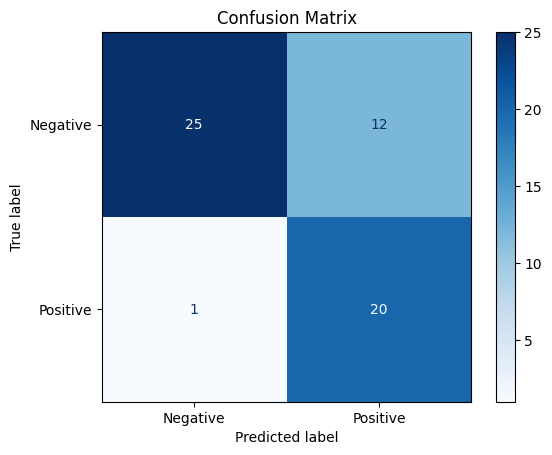


Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.68      0.79        37
    Positive       0.62      0.95      0.75        21

    accuracy                           0.78        58
   macro avg       0.79      0.81      0.77        58
weighted avg       0.84      0.78      0.78        58

Number of selected features: 53
Shape of SHAP values: (277, 53)


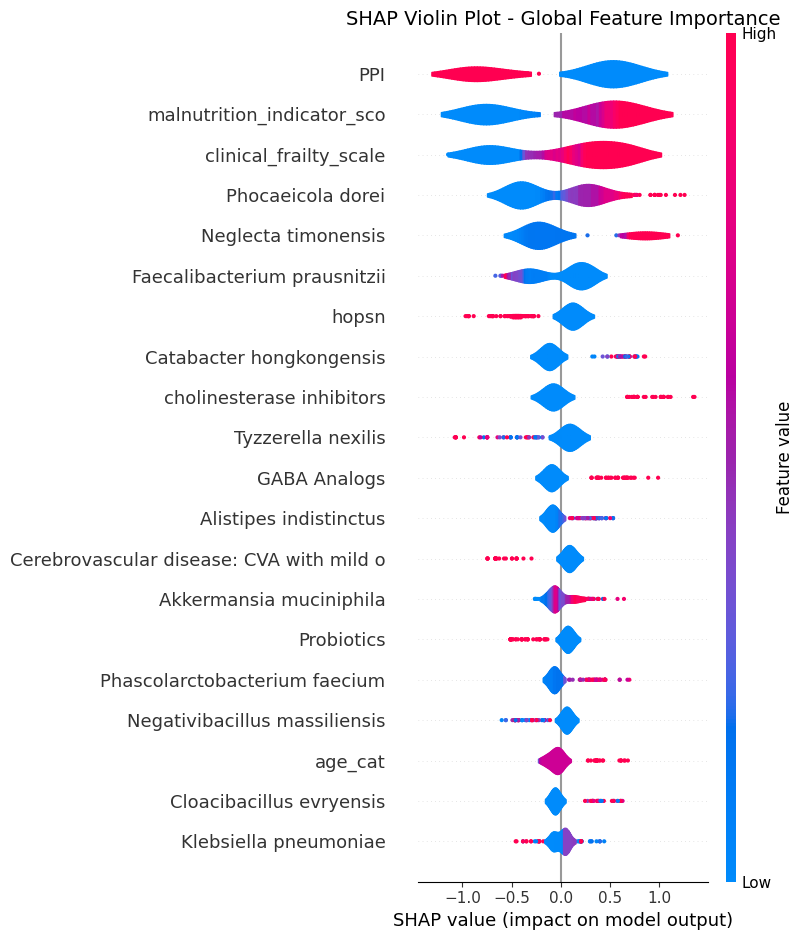

Overlap bacteria found: {'Desulfovibrio_fairfieldensis', 'Klebsiella_pneumoniae', 'GGB3463_SGB4621', 'Phascolarctobacterium_faecium', 'GGB46116_SGB63877', 'Negativibacillus_massiliensis', 'Akkermansia_muciniphila', 'Clostridiaceae_bacterium', 'Phocaeicola_massiliensis', 'Alistipes_shahii', 'Blautia_producta', 'Bacteroides_cellulosilyticus', 'Bifidobacterium_longum', 'Eubacterium_siraeum', 'Evtepia_gabavorous', 'Lachnospiraceae_bacterium', 'Faecalibacterium_prausnitzii', 'GGB9712_SGB15244', 'Bacteroides_intestinalis', 'Phocaeicola_dorei', 'Bacteroides_stercoris', 'Neglecta_timonensis', 'GGB3005_SGB3996', 'Clostridia_bacterium', 'GGB9347_SGB14313', 'GGB3746_SGB5089', 'GGB3510_SGB4687', 'Gemmiger_formicilis', 'Alistipes_indistinctus', 'Clostridia_unclassified_SGB14844', 'Acidaminococcus_intestini', 'Catabacter_hongkongensis', 'Anaeromassilibacillus_sp_An250', 'Intestinimonas_butyriciproducens', 'Streptococcus_lutetiensis', 'GGB9176_SGB14114', 'GGB9581_SGB14999', 'Cloacibacillus_evryensis'

In [14]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix, 
    classification_report, ConfusionMatrixDisplay
)

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# Constants and Configuration
print(f"Experiment number: {experiment_number} | Seed number: {seed}")
# seed = experiment_seed  # Replace with your experiment seed
test_size = 0.25
gpu_device = "hist"

# Function to check for overlaps between train and test data
def check_for_overlap(train_data, test_data):
    """
    Checks for overlapping Sample ID and study_id between train and test datasets.
    """
    # Check for overlapping Study IDs
    overlap_study_ids = set(train_data["study_id"]) & set(test_data["study_id"])
    if overlap_study_ids:
        print(f"Overlap Study ID found: {overlap_study_ids}")
    else:
        print("No overlap Study ID found.")

    # Check for overlapping Sample IDs
    overlap_sample_ids = set(train_data["Sample ID"]) & set(test_data["Sample ID"])
    if overlap_sample_ids:
        print(f"Overlap Sample ID found: {overlap_sample_ids}")
    else:
        print("No overlap Sample ID found.")

def check_for_bacteria(list_a, list_b):
    """
    Checks for overlapping bactertia from list_a and list list_b database and predicted bacteria.
    """
    # Check for overlapping Study IDs
    list_a = [item.replace(" ", "_") for item in list_a]
    list_b = [item.replace(" ", "_") for item in list_b]
    
    overlap_bacteria = set(list_a) & set(list_b)
    if overlap_bacteria:
        print(f"Overlap bacteria found: {overlap_bacteria}")
    else:
        print("No overlap bacteria found.")
    return overlap_bacteria

        
def preprocess_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)
    
    # Select feature columns
    feature_columns = [col for col in df.columns if col not in columns_to_drop]

    # Convert feature columns to float64 to ensure compatibility
    train_data[feature_columns] = train_data[feature_columns].astype(np.float64)
    test_data[feature_columns] = test_data[feature_columns].astype(np.float64)

    # Normalize the feature columns
    scaler = StandardScaler()
    train_data.loc[:, feature_columns] = scaler.fit_transform(train_data[feature_columns])
    test_data.loc[:, feature_columns] = scaler.transform(test_data[feature_columns])

    return train_data, test_data, feature_columns

# Function to compute class weights
def compute_weights(y_train):
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0]
    return scale_pos_weight

# Define Optuna Objective Function
def objective(trial, X_train, y_train, scale_pos_weight, seed):
    print(f"Seed in the model {seed} on Device {device}")
    # Feature selection parameters
    threshold = trial.suggest_categorical('threshold', ['median', 'mean', '0.5*mean', '1.5*mean', 'very_low'])
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])
    norm_order = trial.suggest_int('norm_order', 1, 2)
    threshold_value = -1e10 if threshold == 'very_low' else threshold

    # Feature selection
    selector = SelectFromModel(
        estimator=XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight= scale_pos_weight,
            random_state=seed,
            tree_method=gpu_device, 
            device=device
        ),
        threshold=threshold_value,
        max_features=max_features,
        norm_order=norm_order
    )
    
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)

    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,
        'seed': seed,
        'tree_method': gpu_device,
        'device': device
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=trial.suggest_int("n_estimators", 50, 300),
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        y_val_pred = model.predict(dval)
        y_val_pred_binary = (y_val_pred >= 0.5).astype(int)
        f1_scores.append(f1_score(y_val_fold, y_val_pred_binary))
    return np.mean(f1_scores)

# Main Program
columns_to_drop = ["Sample ID", "study_id", "Alzheimers", "Date Sample", "age", "Dementia Other"] # "malnutrition_indicator_sco", "clinical_frailty_scale", "PPI", 

train_data, test_data, feature_columns = preprocess_data(clinical_microbiome_df, columns_to_drop, test_size, seed)
X_train = deepcopy(train_data[feature_columns].values)
y_train = np.array(train_data["Alzheimers"].values)
X_test = deepcopy(test_data[feature_columns].values)
y_test = np.array(test_data["Alzheimers"].values)
scale_pos_weight = compute_weights(y_train)

# Run Optuna Optimization
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=seed))
study.optimize(lambda trial: objective(trial, X_train, y_train, scale_pos_weight, seed), n_trials=100)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Apply Final Model
final_selector = SelectFromModel(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=seed,
        tree_method=gpu_device,
        device=device,
        scale_pos_weight=scale_pos_weight
    ),
    
    threshold=-1e10 if best_params['threshold'] == 'very_low' else best_params['threshold'],
    max_features=best_params['max_features'],
    norm_order=best_params['norm_order']
)

final_selector.fit(X_train, y_train)
X_train_selected = final_selector.transform(X_train)
X_test_selected = final_selector.transform(X_test)

# Train Final Model
final_model_params = {
    **{k: v for k, v in best_params.items() if k not in ['threshold', 'norm_order', 'max_features', 'n_estimators']},
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'seed': seed,
    'tree_method': gpu_device,
    'device': device
}

dtrain_final = xgb.DMatrix(X_train_selected, label=y_train)
dtest_final = xgb.DMatrix(X_test_selected)

final_model = xgb.train(
    params=final_model_params,
    dtrain=dtrain_final,
    num_boost_round=best_params['n_estimators'],
)

# Predictions and Evaluation
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print("\nTest Metrics:")
print(f"ROC AUC: {auc}\nAccuracy: {accuracy}\nF1 Score: {f1}\nConfusion Matrix:\n{conf_matrix}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_test_pred_binary, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)

# Extract feature names for selected features
selected_feature_names = [feature_columns[i] for i in final_selector.get_support(indices=True)]
print(f"Number of selected features: {len(selected_feature_names)}")

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train_selected)

# Step 2: Compute SHAP values
shap_values = explainer(X_train_selected, check_additivity=False)

# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [15]:
auc

np.float64(0.8146718146718146)

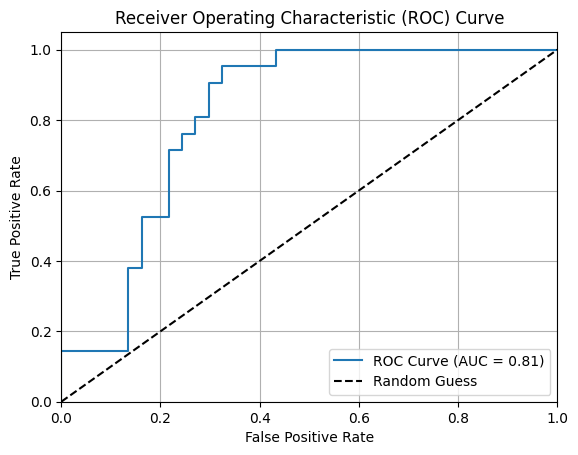

In [16]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [17]:
accuracy

0.7758620689655172

In [18]:
f1

np.float64(0.7547169811320755)

In [19]:
conf_matrix

array([[25, 12],
       [ 1, 20]])

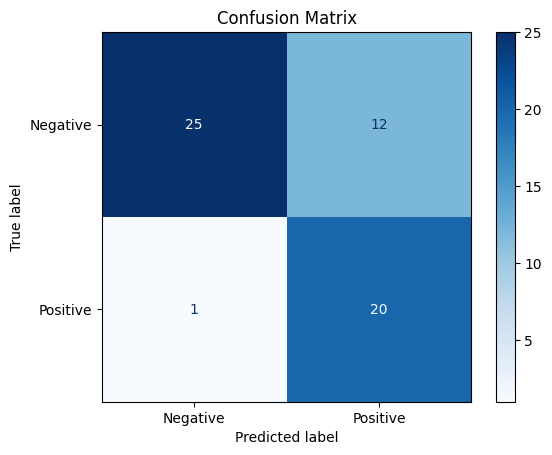

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

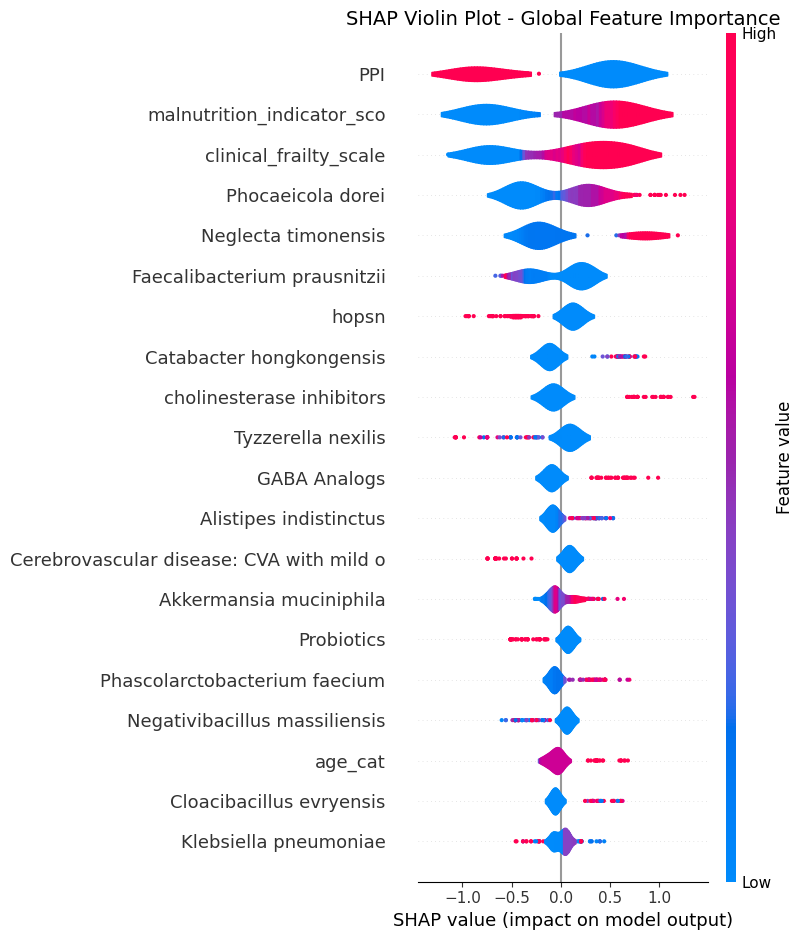

Overlap bacteria found: {'Desulfovibrio_fairfieldensis', 'Klebsiella_pneumoniae', 'GGB3463_SGB4621', 'Phascolarctobacterium_faecium', 'GGB46116_SGB63877', 'Negativibacillus_massiliensis', 'Akkermansia_muciniphila', 'Clostridiaceae_bacterium', 'Phocaeicola_massiliensis', 'Alistipes_shahii', 'Blautia_producta', 'Bacteroides_cellulosilyticus', 'Bifidobacterium_longum', 'Eubacterium_siraeum', 'Evtepia_gabavorous', 'Lachnospiraceae_bacterium', 'Faecalibacterium_prausnitzii', 'GGB9712_SGB15244', 'Bacteroides_intestinalis', 'Phocaeicola_dorei', 'Bacteroides_stercoris', 'Neglecta_timonensis', 'GGB3005_SGB3996', 'Clostridia_bacterium', 'GGB9347_SGB14313', 'GGB3746_SGB5089', 'GGB3510_SGB4687', 'Gemmiger_formicilis', 'Alistipes_indistinctus', 'Clostridia_unclassified_SGB14844', 'Acidaminococcus_intestini', 'Catabacter_hongkongensis', 'Anaeromassilibacillus_sp_An250', 'Intestinimonas_butyriciproducens', 'Streptococcus_lutetiensis', 'GGB9176_SGB14114', 'GGB9581_SGB14999', 'Cloacibacillus_evryensis'

In [21]:
# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

Shape of SHAP values: (277, 53)


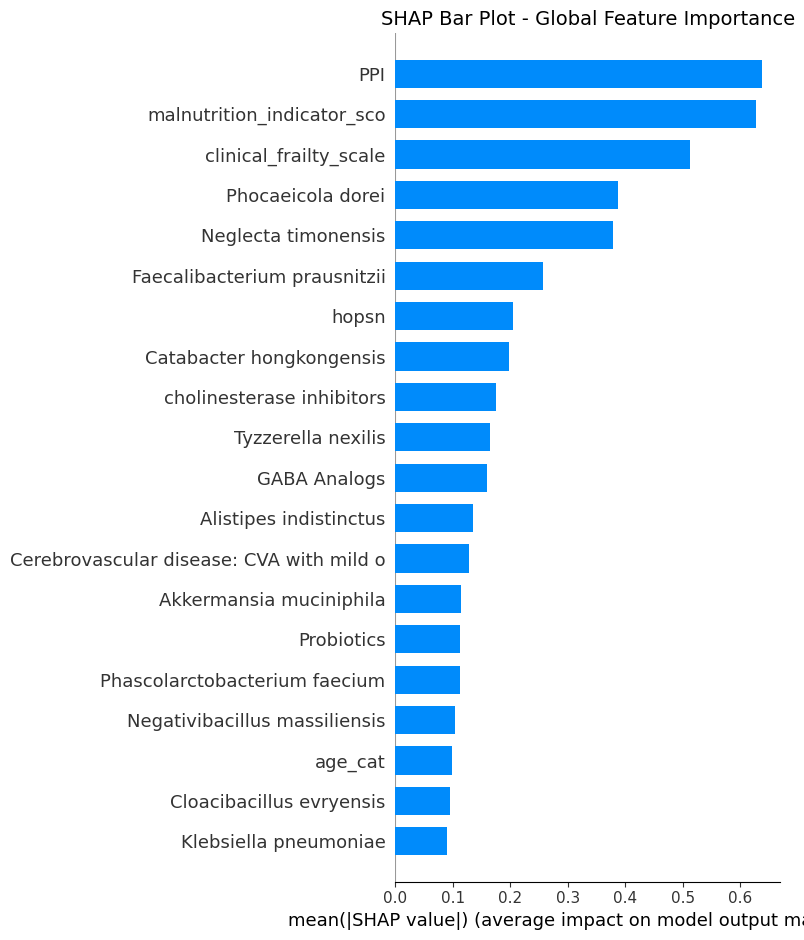

Overlap bacteria found: {'Desulfovibrio_fairfieldensis', 'Klebsiella_pneumoniae', 'GGB3463_SGB4621', 'Phascolarctobacterium_faecium', 'GGB46116_SGB63877', 'Negativibacillus_massiliensis', 'Akkermansia_muciniphila', 'Clostridiaceae_bacterium', 'Phocaeicola_massiliensis', 'Alistipes_shahii', 'Blautia_producta', 'Bacteroides_cellulosilyticus', 'Bifidobacterium_longum', 'Eubacterium_siraeum', 'Evtepia_gabavorous', 'Lachnospiraceae_bacterium', 'Faecalibacterium_prausnitzii', 'GGB9712_SGB15244', 'Bacteroides_intestinalis', 'Phocaeicola_dorei', 'Bacteroides_stercoris', 'Neglecta_timonensis', 'GGB3005_SGB3996', 'Clostridia_bacterium', 'GGB9347_SGB14313', 'GGB3746_SGB5089', 'GGB3510_SGB4687', 'Gemmiger_formicilis', 'Alistipes_indistinctus', 'Clostridia_unclassified_SGB14844', 'Acidaminococcus_intestini', 'Catabacter_hongkongensis', 'Anaeromassilibacillus_sp_An250', 'Intestinimonas_butyriciproducens', 'Streptococcus_lutetiensis', 'GGB9176_SGB14114', 'GGB9581_SGB14999', 'Cloacibacillus_evryensis'

In [22]:
# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Bar Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="bar"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [23]:
measures = ["xgboost", seed, experiment_number, accuracy, auc, f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
measures_df = pd.DataFrame([measures], columns=columns)
measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,xgboost,1770168448,10,0.775862,0.814672,0.754717


In [24]:
output_path = "output"
measures_path = f"{output_path}{os.sep}xgboost_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
measures_path

'output/xgboost_experiment10_measures.csv'

In [25]:
measures_df.to_csv(measures_path, index=False)